# Лабораторная работа № 8
## Динамические сети

#### Выполнил: Цапков А.М.

**Целью работы** является исследование свойств некоторых динамических нейронных сетей,алгоритмов обучения, а также применение сетей в задачах аппроксимации функций и распознавания динамических образов.

In [1]:
import neurolab as nl
import numpy as np
import numpy.matlib
from sklearn.metrics import mean_squared_error
import pyrenn
from matplotlib import pyplot as plt
import math
import neurolab as nl
import random
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from sklearn.neural_network import MLPRegressor
from fireTS.models import NARX

**Вариант №4:** 

1. $10/1848$
2. $g(k) = \sin{(\sin{(k)}k^3 − 10)}, \: k \in [1.56, 3.12]$
3. $u(k) = \sin{(k^2 − 7k)}$

In [2]:
date = "1913-05-01"
# a = 1.56
# b = 3.12
R = [0, 1, 5] # delays

def g(k):
    return np.sin(np.sin(k) * k**3 - 10)

def u(k):
    return np.cos(-k**2 - 8*k) + np.cos(k)**2

def f(k):
    y = [0.]
    for i in k:
        y.append(y[-1] / (1 + y[-1]**2) + u(i)**3)
    return y[:-1]

### Задание №1

Построить и обучить *сеть прямого распространения с запаздыванием (Focused Time-DelayNeural Network, FTDNN)*, которая будет аппроксимировать последовательность чисел Вольфа, а также выполнить многошаговый прогноз.

Формируем входные данные:

In [3]:
df = pd.read_csv('wolfie.csv', sep=';', header=None)
df.head()

,0,1,2,3,4,5,6
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1


In [4]:
df = df.iloc[:, 0:4]
df.drop([2], axis=1, inplace=True)

df[0] = df[0].astype(str)
df[1] = df[1].astype(str)
df.index = pd.to_datetime(df[0] + '-' + df[1])

df.drop([0], axis=1, inplace=True)
df.drop([1], axis=1, inplace=True)

df.head()

,3
1749-01-01,96.7
1749-02-01,104.3
1749-03-01,116.7
1749-04-01,92.8
1749-05-01,141.7


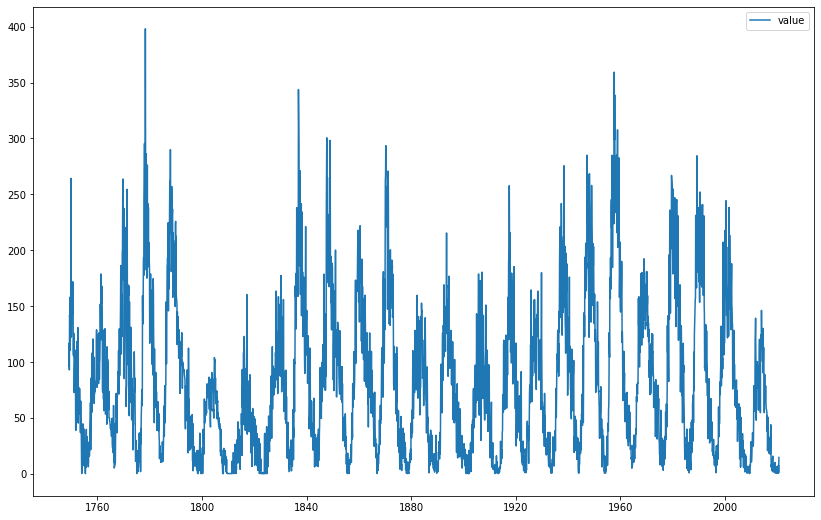

In [5]:
plt.figure(figsize=(14, 9))
plt.plot(df, label="value")
plt.legend()
plt.show()

In [6]:
values = df.values.flatten()

Усредняющий фильтр **smooth** с заданной шириной окна:

In [7]:
def smooth(a, windowWidth):
    out0 = np.convolve(a, np.ones(windowWidth, dtype=int), 'valid') / windowWidth    
    r = np.arange(1, windowWidth-1,2)
    start = np.cumsum(a[:(windowWidth-1)-1])[::2] / r
    stop = (np.cumsum(a[:-(windowWidth-1):-1])[::2] / r)[::-1]
    return np.concatenate((start, out0, stop)) / 300

Зададим ширину окна и сгладим данные:

In [8]:
widthWindow = 12
smoothValues = smooth(values, widthWindow)

Обновим данные в датафрейме на сглаженные и зададим начало в соответствии с вариантом.

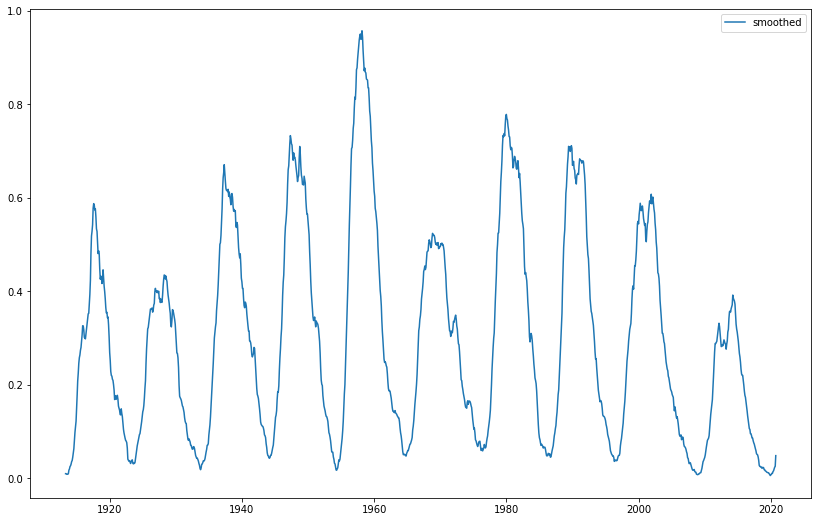

In [9]:
shift = df.values.size - smoothValues.size
df.iloc[shift:] = smoothValues[:, np.newaxis]

df = df[df.index >= pd.to_datetime(date)]

plt.figure(figsize=(14, 9))
plt.plot(df, label="smoothed")
plt.legend()
plt.show()

Сформируем обучающее множество (сразу с задержками) и тестовое множество для многошагового прогноза.

In [10]:
deep = 5

In [11]:
trainSize = int(len(df) * 0.7)
train = df[:trainSize]
test = df[trainSize:]

trainData = train.values.squeeze()
xTrain = np.array([trainData[i:i + deep] for i in range(len(trainData) - deep)])
yTrain = train.iloc[deep:].values

testData = test.values.squeeze()
xTest = np.array([testData[i:i + deep] for i in range(len(testData) - deep)])
yTest = test.iloc[deep:].values

Создадим и обучим нейронную сеть:

In [12]:
model = Sequential()
model.add(Dense(12, input_dim=deep, activation='tanh'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(xTrain, yTrain, epochs=60, batch_size=2, verbose=0)

Выход сети:

In [15]:
predictTrain = model.predict(xTrain)

MSE = mean_squared_error(yTrain, predictTrain)
print('MSE = {}'.format(MSE))
print('RMSE = {}'.format(np.sqrt(MSE)))

MSE = 0.0001295870774682795
RMSE = 0.011383631998104977


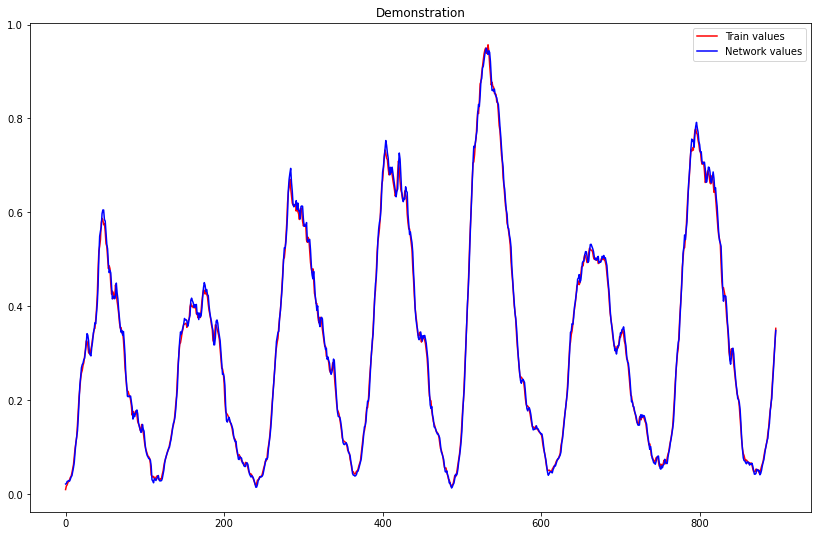

In [16]:
plt.figure(figsize=(14, 9))

plt.plot(yTrain, color='red')
plt.plot(predictTrain, color='blue')

plt.legend(['Train values', 'Network values'])
plt.title("Demonstration")
plt.show()

In [17]:
predictTest = model.predict(xTest)

MSE = mean_squared_error(yTest, predictTest)
print('MSE = {}'.format(MSE))
print('RMSE = {}'.format(np.sqrt(MSE)))

MSE = 0.00010378577810481541
RMSE = 0.01018753052043602


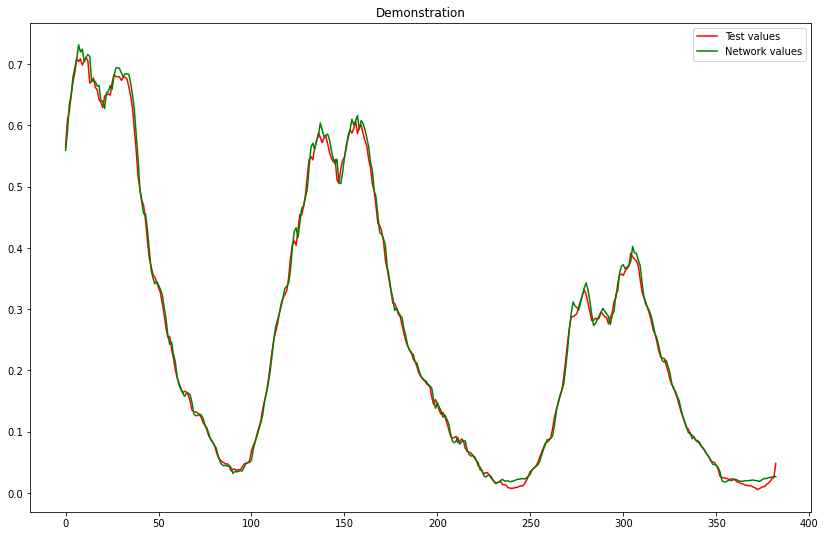

In [18]:
plt.figure(figsize=(14, 9))

plt.plot(yTest, color='red')
plt.plot(predictTest, color='green')

plt.legend(['Test values', 'Network values'])
plt.title("Demonstration")
plt.show()

### Задание №2

Построить и обучить *сеть прямого распространения с распределенным запаздыванием (Distributed Time-Delay Neural Network, TDNN)*, которая будет выполнять распознавание динамического образа.

Сгенерируем набор из  точек:

In [19]:
p1_k = np.linspace(0, 1, int(1 / 0.025), endpoint=True)

# main signal
p1 = np.sin(4 * np.pi * p1_k)

t1 = np.ones(len(p1_k)) * (-1)


p2_k = np.linspace(2.47, 4.26, int(1.79 / 0.025), endpoint=True)

# predict signal
p2 = np.cos(np.cos(p2_k) * p2_k * p2_k)

t2 = np.ones(len(p2_k))

# delay
R = np.array([7, 1, 3])

p2 = p2.reshape(1, p2.shape[0])
t2 = t2.reshape(1, t2.shape[0])

In [20]:
P = np.concatenate((numpy.matlib.repmat(p1, 1, R[0]), p2,
                    numpy.matlib.repmat(p1, 1, R[1]), p2,
                    numpy.matlib.repmat(p1, 1, R[2]), p2), axis=1).reshape(-1, 1)

T = np.concatenate((numpy.matlib.repmat(t1, 1, R[0]), t2,
                    numpy.matlib.repmat(t1, 1, R[1]), t2,
                    numpy.matlib.repmat(t1, 1, R[2]), t2), axis=1).reshape(-1, 1)

T = T.ravel() # makes 1-D array
P = P.ravel()

Создадим и обучим сеть с задержками, равными $5$:

In [21]:
nn = pyrenn.CreateNN([1, 8, 1], dIn=[5], dIntern=[5])

nn = pyrenn.train_LM(P, T, nn, E_stop=1e-5, k_max=200)

Maximum number of iterations reached


Выход сети:

In [22]:
output = pyrenn.NNOut(P, nn)

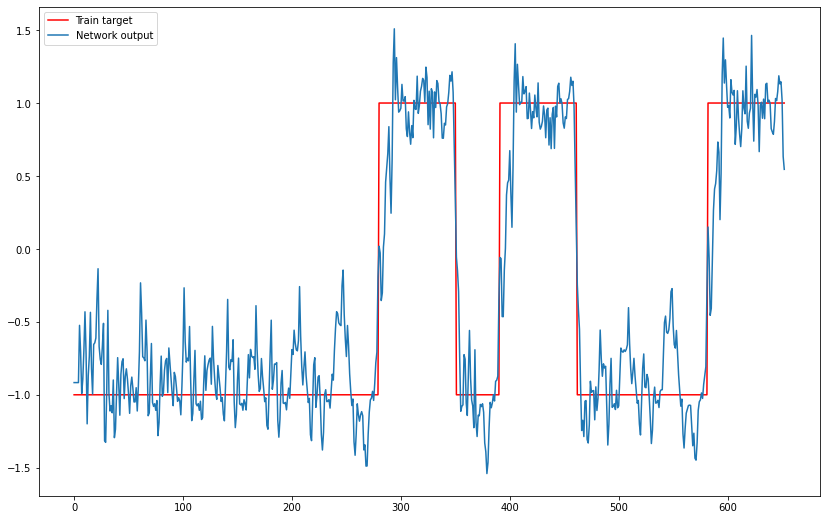

In [23]:
plt.figure(figsize=(14, 9))
plt.plot(T, color='red')
plt.plot(output)
plt.legend(['Train target', 'Network output'])
plt.show()

In [24]:
output[output >= 0] = 1.0
output[output < 0] = -1.0

MSE = mean_squared_error(T.reshape(T.shape[0]), output)
print('MSE = {}'.format(MSE))
print('RMSE = {}'.format(np.sqrt(MSE)))

MSE = 0.07350689127105667
RMSE = 0.2711215433547409


Для проверки качества распознавания сформируем новое обучающее множество, изменив одно из значений $R$.

In [25]:
P2 = np.concatenate((numpy.matlib.repmat(p1, 1, R[0]), p2,
                    numpy.matlib.repmat(p1, 1, R[1]), p2,
                    numpy.matlib.repmat(p1, 1, 12), p2), axis=1).reshape(-1, 1)

T2 = np.concatenate((numpy.matlib.repmat(t1, 1, R[0]), t2,
                    numpy.matlib.repmat(t1, 1, R[1]), t2,
                    numpy.matlib.repmat(t1, 1, 12), t2), axis=1).reshape(-1, 1)

T2 = T2.ravel() # makes 1-D array
P2 = P2.ravel()

In [26]:
output2 = pyrenn.NNOut(P2, nn)

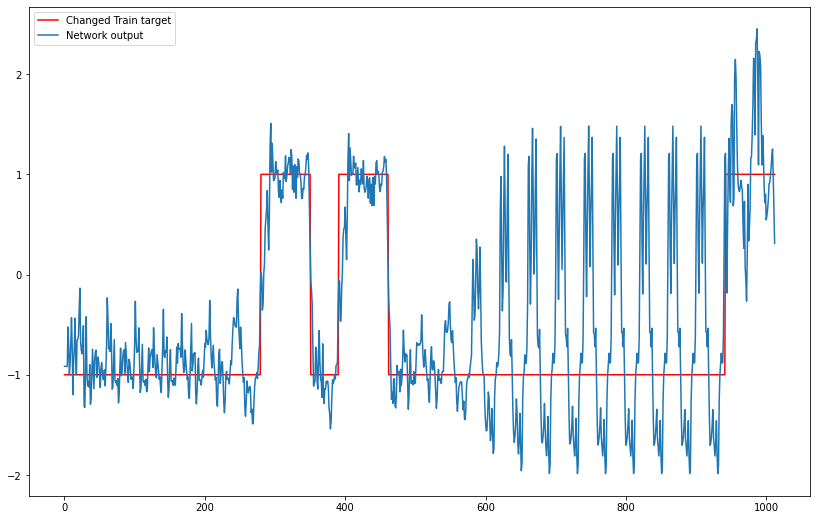

In [27]:
plt.figure(figsize=(14, 9))

plt.plot(T2, color='red')
plt.plot(output2)
plt.legend(['Changed Train target', 'Network output'])
plt.show()

In [28]:
output2[output2 >= 0] = 1.0
output2[output2 < 0] = -1.0

MSE = mean_squared_error(T2, output2)
print('MSE = {}'.format(MSE))
print('RMSE = {}'.format(np.sqrt(MSE)))

MSE = 0.45804540967423496
RMSE = 0.6767905212650625


### Задание №3

Построить и обучить *нелинейную авторегрессионную сеть с внешними входами (Non-linearAutoRegressive network with eXogeneous inputs, NARX)*, которая будет выполнять аппроксимациютраектории динамической системы, также выполнить многошаговый прогноз значений системы.

Сформируем данные:

In [29]:
k = np.linspace(0, 10, (int)(10/0.01))

y = f(k)

In [30]:
inpt = u(k)[:, np.newaxis]
target = y

In [31]:
# data parameters:
delay = 3
trainSize = 700
testSize = 200
validSize = 97
shift=10

xTrain = k[:700]
xTest = k[700:900]
xValid = k[900:997]

yTrain = y[:700]
yTest = y[700:900]
yValid = y[900:997]

Создадим и обучим сеть:

In [32]:
narx = NARX(MLPRegressor(hidden_layer_sizes=(10, 10)), solver='lbfgs', max_iter=600,
                         auto_order=2, exog_order=[2], exog_delay=[delay])

In [33]:
narx.fit(inpt, target)

/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Аппроксимируем систему:

In [34]:
output = narx.predict(inpt, target, step=1)

output[np.isnan(output)] = 0
MSE = mean_squared_error(target, output)
print('MSE = {}'.format(MSE))
print('RMSE = {}'.format(np.sqrt(MSE)))

MSE = 0.25554208810640966
RMSE = 0.505511709168452


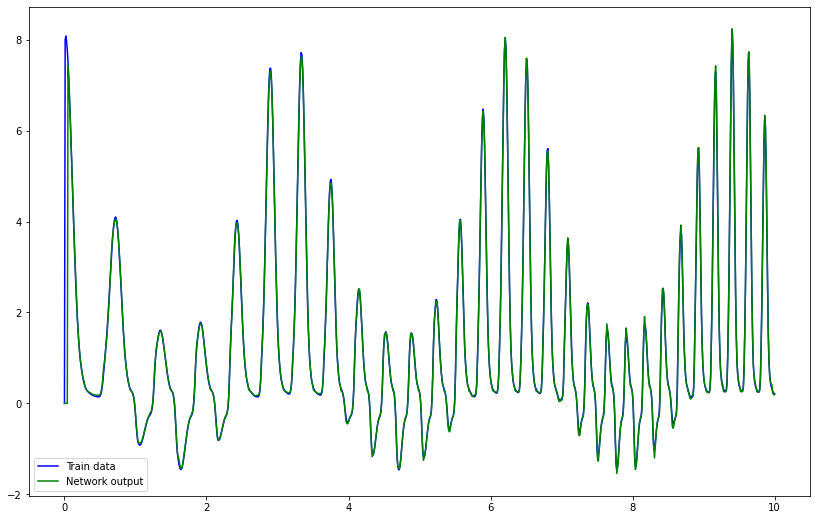

In [35]:
plt.figure(figsize=(14, 9))

plt.plot(k, y, color='blue')
plt.plot(k, output, color='green')
plt.legend(['Train data', 'Network output'])
plt.show()

Выполним многошаговый прогноз: обучим и рассчитаем выход сети для тестового подмножества. 

In [36]:
narx = NARX(MLPRegressor(hidden_layer_sizes=(10, 10)), solver='lbfgs', max_iter=600,
                         auto_order=2, exog_order=[delay], exog_delay=[delay])
narx.fit(inpt, target)

/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [37]:
inputTest = u(xTest)[:, np.newaxis]
targetTest = yTest
outputTest = narx.predict(inputTest, targetTest, step=3)

In [38]:
outputTest[np.isnan(outputTest)] = 0
MSE = mean_squared_error(targetTest, outputTest)
print('MSE = {}'.format(MSE))
print('RMSE = {}'.format(np.sqrt(MSE)))

MSE = 0.5224064540137066
RMSE = 0.7227769047318173


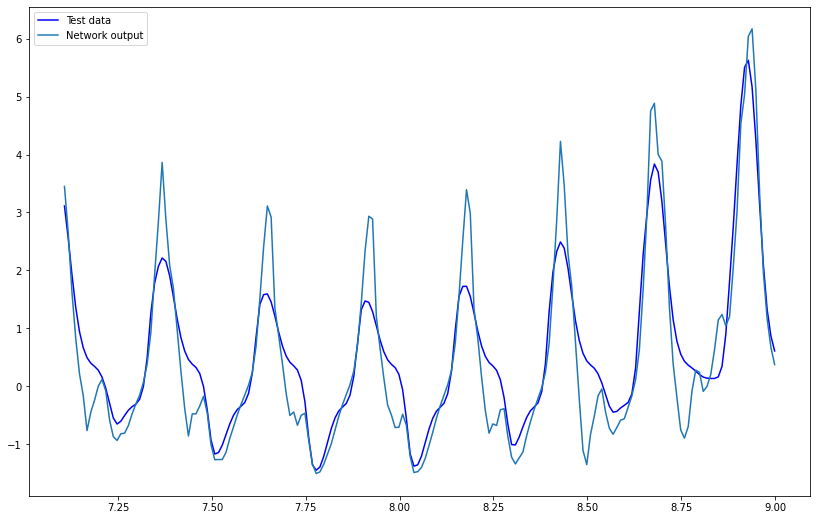

In [39]:
plt.figure(figsize=(14, 9))

plt.plot(xTest[shift:], yTest[shift:], color='blue')
plt.plot(xTest[shift:], outputTest[shift:])
plt.legend(['Test data', 'Network output'])
plt.show()

# Выводы:
Наиболее интересными из динамических сетей для меня кажутся рекурентные. С их помощью были созданы такие сети как GPT или BERT которые способны делать то, что ранее казалось способны сделать только люди. Если говорить о результатах заданий, то в первом мы снова видим "запоминание" промежутков, как в 4-й ЛР.